In [1]:
import fastai.tabular.all as ft
import pandas as pd


import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [2]:
df = pd.read_csv("diabetes.csv")

In [3]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [4]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [7]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Separar en categoricas y continuas

In [9]:
cat_names = []
cont_names = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']
cat_names= []
y_names = ["Outcome"]

In [10]:
x = ft.range_of(df)
#x = list(range(len(df)))

In [11]:
valid_cut = len(df)-60

In [12]:
src = ft.TabularPandas(df,
                      procs = [ft.Category], #"Transformadas". Categorizar, ft.FillMissing
                       #Las categorias las convierte a números.
                       #FillMissing, podemos usar estrategias de llenado de valores faltantes
                           #Add column, Agrega si el valor era NA o no
                      cat_names=cat_names, cont_names=cont_names, y_names=y_names,
                       y_block = ft.CategoryBlock,
                      splits = (x[:valid_cut], x[valid_cut:]))#Para train y test

In [15]:
dls = src.dataloaders(bs=16) #Revisar el tamaño del batch de acuerdo a la cantidad de columnas
#Además, podemos tener batch sizes más grandes que cuando trabajamos con imágenes

In [16]:
batch = dls.one_batch()

In [17]:
cat, cont, y = batch

In [18]:
cat.shape

torch.Size([16, 0])

In [19]:
cont.shape

torch.Size([16, 7])

In [20]:
y.size()

torch.Size([16, 1])

In [35]:
learn = ft.tabular_learner(dls,
                           opt_func=ft.ranger, 
                           metrics=ft.accuracy)

In [36]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=7, out_features=200, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=200, out_features=100, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=2, bias=True)
    )
  )
)

In [24]:
learn.summary()

TabularModel (Input shape: ['16 x 0', '16 x 7'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          16 x 7               14         True      
________________________________________________________________
BatchNorm1d          16 x 7               14         True      
________________________________________________________________
Linear               16 x 200             1,400      True      
________________________________________________________________
ReLU                 16 x 100             0          False     
________________________________________________________________
BatchNorm1d          16 x 200             400        True      
________________________________________________________________
Linear               16 x 100             20,000     True      
________________________________________________________________
ReLU                 16 x 100             0          False     
_________________________________________________

SuggestedLRs(lr_min=0.0019054606556892395, lr_steep=0.007585775572806597)

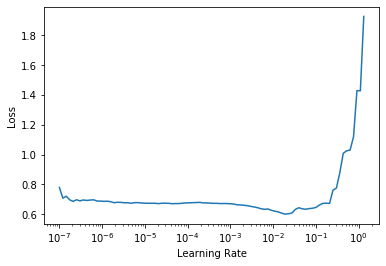

In [25]:
learn.lr_find()

In [26]:
learn.fit_one_cycle(20, 1e-3, div=2, pct_start=0.5)

epoch,train_loss,valid_loss,accuracy,time
0,0.631526,0.593188,0.783333,00:00
1,0.562345,0.493370,0.883333,00:00
2,0.515325,0.456111,0.883333,00:00
3,0.491284,0.438061,0.850000,00:00
4,0.477252,0.440440,0.833333,00:00
5,0.469512,0.451833,0.833333,00:00
6,0.466048,0.464682,0.766667,00:00
7,0.460502,0.463647,0.816667,00:00
8,0.462744,0.450596,0.816667,00:00
9,0.465553,0.452433,0.816667,00:00


### Mejorando el modelo

- Modificamos layers (lista con capas intermedias)
- Ajustar los tamaños de los embedings (emb_szs)
- Configurar variable config

- -Los modelos de Fastai ya son bastante buenos (ahorrarnos crear el nuestro) 

In [43]:
learn = ft.tabular_learner(dls,
                          #loss_func = ft.accuracy,
                         emb_szs= {'Outcome':18}, #Cambiar el tamaño de los embedings, de la dimension
                          layers = [32,64,128,64], #Numero de neuronas en cada capa oculta
                          config = ft.tabular_config(act_cls=nn.LeakyReLU(inplace=True)),
                           #ps(dropout), embedingdropout, sigmoide, batchnorm, activacion
                          opt_func = ft.ranger,
                           metrics = ft.accuracy)

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.12022644281387329)

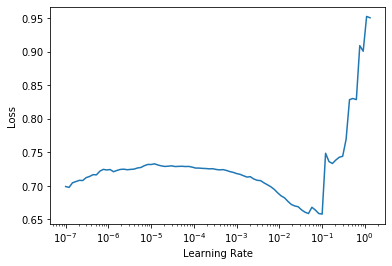

In [44]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, 1e-3, div=2, pct_start=0.5)

epoch,train_loss,valid_loss,accuracy,time
0,0.694338,0.689591,0.516667,00:00
1,0.636650,0.608755,0.750000,00:00
2,0.588720,0.541971,0.850000,00:00
3,0.545186,0.501092,0.850000,00:00
4,0.521961,0.491240,0.816667,00:00
5,0.489386,0.473956,0.816667,00:00
6,0.490303,0.474538,0.783333,00:00
7,0.483315,0.485115,0.783333,00:00
8,0.486540,0.495427,0.800000,00:00
9,0.492214,0.481370,0.783333,00:00
